In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, UpSampling2D, Conv2DTranspose, MaxPooling2D, Concatenate, SeparableConv2D, Activation
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import seaborn as sns
from matplotlib import rcParams

from utils import *

In [ ]:
d  = load_selected_losses(['bilinear'])
d

In [ ]:
sns.set_style('whitegrid')
g = sns.FacetGrid(data=d[d['training mode'] != 'validating'], hue='regularisation function', col='learning rate', palette='Reds', height=7.5, aspect=0.5)
g = g.map(sns.lineplot, 'epoch', 'value').add_legend()
g.set_axis_labels("Epoch", "Training Loss (PSNR)")
g.savefig('visualisations/hyperparameter_search.pdf')
sns.reset_defaults()

In [2]:
patna_area_tiffs = load_tiff_paths('tiffs//patna_area_tiffs')
all_india_2020 = load_tiff_paths('tiffs//all_india_2020')
area_of_interest = load_shapefile('shapefiles//india_kilns_classified_v3//india_kiln_types_v3.shp')

In [3]:
weights = get_tiff_selection_probs(tiff_paths=all_india_2020, validation_tiff_num=13, shapefile=area_of_interest)
weights

[11,
 8,
 4,
 123,
 10,
 6,
 11,
 11,
 21,
 91,
 8,
 21,
 17,
 6,
 81,
 33,
 34,
 16,
 42,
 40,
 25,
 63]

In [ ]:
 for tv in [True, False]:
    for tiff in all_india_2020:
        create_kiln_mask(tiff, area_of_interest, trio=tv)

In [ ]:
tiff_kilns = []
for tiff in all_india_2020:
    _, _, kilns = areas_covered(tiff, area_of_interest)
    tiff_kilns.append(kilns)
tiff_kilns = pd.concat(tiff_kilns)

In [ ]:
plt.hist(area_of_interest.probabilit)

In [ ]:
# def create_kiln_mask(tiff_path, shapefile, plot=False, trio=False):
    # coords, tiff_array, covered_regions = areas_covered(tiff_path, shapefile)
    # long_min, lat_min, long_max, lat_max = coords
    # kiln_type_axs_mapping = {'bull_trench':0, 'zigzag':1, 'false_positive':2}

    # if trio:
    #     kiln_mask = np.zeros(shape=(4096,4096,3))
    #     kiln_mask[:,:,2] = 1
    # else:
    #     covered_regions = covered_regions[covered_regions.kiln_type != 'false_positive']
    #     kiln_mask = np.zeros(shape=(4096,4096))
    # kiln_locations = []

    # kiln_mask2 = np.zeros(shape=(4096,4096))
    
    # if plot:
    #     # if trio:
    #     #     f, axs = plt.subplots(1, 5, figsize=(30, 30))
    #     # else:
    #     f, axs = plt.subplots(1, 3, figsize=(20, 7))

    # for idx, kiln in covered_regions.iterrows():    
    #     if plot:
    #         x = kiln.geometry.representative_point().x
    #         y = kiln.geometry.representative_point().y
    #         trans_x = floor(((x-long_min)/(long_max-long_min))*tiff_array.shape[-1])
    #         trans_y = floor(((lat_max-y)/(lat_max-lat_min))*tiff_array.shape[-2])
    #         if not trio:
    #             axs[0].scatter(trans_x, trans_y, color='r')
    #         else:
    #             if kiln.kiln_type == 'bull_trench':
    #                 axs[0].scatter(trans_x, trans_y, color='r')
    #             elif kiln.kiln_type == 'zigzag':
    #                 axs[0].scatter(trans_x, trans_y, color='r')
    #             else:
    #                 axs[0].scatter(trans_x, trans_y, color='r')    

    #     kiln_long_min, kiln_lat_min, kiln_long_max, kiln_lat_max = kiln.geometry.bounds
    #     left = floor(((kiln_long_min-long_min)/(long_max-long_min))*tiff_array.shape[-1])
    #     right = ceil(((kiln_long_max-long_min)/(long_max-long_min))*tiff_array.shape[-1])
    #     top = ceil(((lat_max-kiln_lat_max)/(lat_max-lat_min))*tiff_array.shape[-2])
    #     bottom =  floor(((lat_max-kiln_lat_min)/(lat_max-lat_min))*tiff_array.shape[-2])
    #     kiln_locations.append((left, right, top, bottom))

    #     #  if plot:
    #     #     if not trio:
    #     #         rect = patches.Rectangle(((left+right)/2, (top+bottom)/2), right-left, bottom-top, linewidth=1, edgecolor='r', facecolor='none')
    #     #         axs[1].add_patch(rect)
    #     #     else:
    #     #         if kiln.kiln_type == 'bull_trench':
    #     #             rect = patches.Rectangle(((left+right)/2, (top+bottom)/2), right-left, bottom-top, linewidth=1, edgecolor='r', facecolor='none')
    #     #             axs[1].add_patch(rect)
    #     #         elif kiln.kiln_type == 'zigzag':
    #     #             rect = patches.Rectangle(((left+right)/2, (top+bottom)/2), right-left, bottom-top, linewidth=1, edgecolor='g', facecolor='g')
    #     #             axs[1].add_patch(rect)
    #     #         else:
    #     #             rect = patches.Rectangle(((left+right)/2, (top+bottom)/2), right-left, bottom-top, linewidth=1, edgecolor='b', facecolor='none')
    #     #             axs[1].add_patch(rect)

    #     for row_i in range(floor(top), ceil(bottom)):
    #         for col_i in range(floor(left), ceil(right)):
    #             kiln_mask2[row_i, col_i] = 1 
    #             lat = abs((top+bottom)/2 - row_i)
    #             long = abs((left+right)/2 - col_i)
    #             if trio:
    #                 kiln_mask[row_i, col_i, kiln_type_axs_mapping[kiln.kiln_type]] = np.exp(-(lat**2 + long**2)/(2*36))
    #                 kiln_mask[row_i, col_i, 2] = 1 - np.exp(-(lat**2 + long**2)/(2*36))
    #             else:
    #                 kiln_mask[row_i, col_i] = np.exp(-(lat**2 + long**2)/(2*36))
    
    # tiff = load_tiff(tiff_path, plot=False)
    # if not plot:
    #     return tiff, kiln_mask, kiln_mask2#, np.array(kiln_locations), covered_regions.kiln_type

    # if trio:
    #     titles = ['kilns marked', 'kilns bounded', 'bull trenches', 'zigzags', 'false postives']
    # else:
    # titles = ['kilns marked', 'no kiln ty']
    for idx, ax in enumerate(axs):
        # ax.set_title(titles[idx])
        ax.axis('off')
    axs[0].imshow(tiff, interpolation='nearest')
    axs[1].imshow(kiln_mask2)
    axs[2].imshow(kiln_mask, cmap='YlOrBr')

    plt.subplots_adjust( wspace=0.01, hspace=0.1)
    plt.savefig(f'visualisations/kiln_marked_with_mask.pdf', backend='PGF')
create_kiln_mask(all_india_2020[13], area_of_interest, plot=True, trio=True)

In [ ]:
train_gen = image_data_generator(batch_size=4, is_training=True, tiff_paths=all_india_2020, 
                    validation_tiff_num=13, shapefile=area_of_interest, weights=weights, trio=True, plot=True)

In [ ]:
t, o = next(train_gen)

In [ ]:
# save_path = 'visualisations/training_progress/constant_image/constant_target.pkl'
# with open(save_path, 'wb') as file:
#         pickle.dump(o2, file)

In [ ]:
def show_predictions(model, inputs, masks, save=False, epoch=None):
    p = model.predict(inputs, verbose=0)
    num_inputs = inputs.shape[0]
    f, axs = plt.subplots(num_inputs, 3, figsize=(12,15))
    titles = ['Input Image', 'Mask', f'Prediction Epoch {epoch}']
    plot_data = zip(titles, [inputs, masks, p])
    for idx, ax, info in zip(np.repeat(range(num_inputs), 3), axs.flatten(), itertools.cycle(plot_data)):
        title, array = info
        if idx == 0:
            ax.set_title(title)
        array = np.clip(array, a_min=0, a_max=1)
        ax.imshow(array[idx])
        ax.axis('off')
    f.tight_layout()

    if save:
        os.makedirs(f'visualisations/training_progress/constant_image/{model.name}/', exist_ok=True)
        plt.savefig(f'visualisations/training_progress/constant_image/{model.name}/model_at_epoch_{epoch}.png', backend='Agg')
        plt.close()

In [ ]:
model_path = f'networks/unet_large/{model.name}/{model.name}_epoch'
with open('visualisations/training_progress/constant_image/constant_target.pkl', 'rb') as f:
    o = pickle.load(f)

with open('visualisations/training_progress/constant_image/constant_input.pkl', 'rb') as f:
    i = pickle.load(f)
for epoch in range(0, 1780, 20):
    model.load_weights(f'{model_path}_{epoch}.h5')
    show_predictions(model, i, o, save=True, epoch=epoch)

In [ ]:
np.sum(o[1][:,:,1] + o[1][:,:,2] + o[1][:,:,0])

In [ ]:
weight_regularizer = None
activation_function = 'elu'
loss_name = 'psnr'
loss_function = lambda pred, true: -1*tf.image.psnr(true, pred, max_val=1)
learning_rate = 0.0001
upsampling_interpolation = 'bilinear'
weight_initializer = tf.keras.initializers.GlorotUniform(seed=123)

model_name = f'unet_small_all_india_2020_{weight_regularizer}_{activation_function}_{loss_name}_{learning_rate}_{upsampling_interpolation}'

def build_model(model_name, learning_rate, activation_function, loss_function, upsampling_interpolation):
    image_dim = (300,300,3)
    input_layer = Input(shape=image_dim, name='orginal_image')

    # Downsampling layers
    conv1 = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation_function, name='first_conv', depthwise_initializer=weight_initializer, pointwise_initializer=weight_initializer)(input_layer)
    conv2 = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation_function, name='second_conv', depthwise_initializer=weight_initializer, pointwise_initializer=weight_initializer)(conv1)
    pool = MaxPooling2D(pool_size=(2,2), strides=2, name='first_pool')(conv2)

    conv3 = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation_function, name='third_conv', depthwise_initializer=weight_initializer, pointwise_initializer=weight_initializer)(pool)
    conv4 = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation_function, name='fourth_conv', depthwise_initializer=weight_initializer, pointwise_initializer=weight_initializer)(conv3)
    pool = MaxPooling2D(pool_size=(2,2), strides=2, name='second_pool')(conv4)

    conv5 = SeparableConv2D(filters=256, kernel_size=(3,3), padding='same', activation=activation_function, name='fifth_conv', depthwise_initializer=weight_initializer, pointwise_initializer=weight_initializer)(pool)
    conv6 = SeparableConv2D(filters=256, kernel_size=(3,3), padding='same', activation=activation_function, name='sixth_conv', depthwise_initializer=weight_initializer, pointwise_initializer=weight_initializer)(conv5)

    # Upsampling Layers with skip connections
    upsample = UpSampling2D(name='first_upsample', interpolation=upsampling_interpolation)(conv6)
    concat1 = Concatenate(name='first_concatenation')([conv4, upsample])
    conv7 = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation_function, name='first_up_conv', depthwise_initializer=weight_initializer, pointwise_initializer=weight_initializer)(concat1)
    conv8 = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation_function, name='second_up_conv', depthwise_initializer=weight_initializer, pointwise_initializer=weight_initializer)(conv7)

    upsample = UpSampling2D(name='second_upsample', interpolation=upsampling_interpolation)(conv8)
    concat = Concatenate(name='second_concatenation')([conv2, upsample])
    conv9 = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation_function, name='third_up_conv', depthwise_initializer=weight_initializer, pointwise_initializer=weight_initializer)(concat)
    conv10 = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation_function, name='fourth_up_conv', depthwise_initializer=weight_initializer, pointwise_initializer=weight_initializer)(conv9)

    final = SeparableConv2D(filters=1, kernel_size=(3,3), padding='same', activation=activation_function, name='final_conv_masker', depthwise_initializer=weight_initializer, pointwise_initializer=weight_initializer, use_bias=False)(conv10)

    model =  Model(inputs=input_layer, outputs=final, name=model_name)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_function)

    return model

model = build_model(model_name, learning_rate, activation_function, loss_function, upsampling_interpolation)

In [ ]:
weight_regularizer = 'l1'
activation_function = 'elu'
loss_name = 'cce'
cce = tf.keras.losses.CategoricalCrossentropy()
epsilon = tf.constant(0.0001)
loss_function = lambda true, pred: tf.image.psnr(true+epsilon, pred+epsilon, max_val=1)*tf.image.ssim(true+epsilon, pred+epsilon, max_val=1.0)*cce(true+epsilon, pred+epsilon)
loss_function = lambda true, pred: cce(true+epsilon, pred+epsilon)
learning_rate = 0.0001
upsampling_interpolation = 'bilinear'
tf.random.set_seed(1212)
model_name = f'unet_large_3_mask_all_india_2020_{weight_regularizer}_{activation_function}_{loss_name}_{learning_rate}_{upsampling_interpolation}'

def build_model(model_name, learning_rate, activation_function, loss_function, upsampling_interpolation):
    image_dim = (300,300,3)
    input_layer = Input(shape=image_dim, name='orginal_image')

    # Downsampling layers
    conv1 = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation_function, name='first_conv')(input_layer)
    conv2 = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation_function, name='second_conv')(conv1)
    pool = MaxPooling2D(pool_size=(2,2), strides=2, name='first_pool')(conv2)

    conv3 = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation_function, name='third_conv')(pool)
    conv4 = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation_function, name='fourth_conv')(conv3)
    pool = MaxPooling2D(pool_size=(2,2), strides=2, name='second_pool')(conv4)

    conv5 = SeparableConv2D(filters=256, kernel_size=(3,3), padding='same', activation=activation_function, name='fifth_conv')(pool)
    conv6 = SeparableConv2D(filters=256, kernel_size=(3,3), padding='same', activation=activation_function, name='sixth_conv')(conv5)
    pool = MaxPooling2D(pool_size=(2,2), strides=2, name='third_pool')(conv6)

    conv7 = SeparableConv2D(filters=512, kernel_size=(3,3), padding='same', activation=activation_function, name='seventh_conv')(pool)
    conv8 = SeparableConv2D(filters=512, kernel_size=(3,3), padding='same', activation=activation_function, name='eighth_conv')(conv7)
    pool = MaxPooling2D(pool_size=(2,2), strides=2, name='fourth_pool')(conv8)

    conv = SeparableConv2D(filters=1024, kernel_size=(3,3), padding='same', activation=activation_function, name='ninth_conv')(pool)
    conv = SeparableConv2D(filters=1024, kernel_size=(3,3), padding='same', activation=activation_function, name='tenth_conv')(conv)

    # Upsampling Layers with skip connections
    upsample = UpSampling2D(name='first_upsample', interpolation=upsampling_interpolation)(conv)
    convt = Conv2DTranspose(filters=1024, kernel_size=(2,2), activation=activation_function, name='first_conv_transpose', kernel_regularizer=weight_regularizer)(upsample)
    concat1 = Concatenate(name='first_concatenation')([conv8, convt])
    conv9 = SeparableConv2D(filters=512, kernel_size=(3,3), padding='same', activation=activation_function, name='first_up_conv')(concat1)
    conv10 = SeparableConv2D(filters=512, kernel_size=(3,3), padding='same', activation=activation_function, name='second_up_conv')(conv9)

    upsample = UpSampling2D(name='second_upsample', interpolation=upsampling_interpolation)(conv10)
    convt = Conv2DTranspose(filters=512, kernel_size=(2,2), activation=activation_function, name='second_conv_transpose', kernel_regularizer=weight_regularizer)(upsample)
    concat = Concatenate(name='second_concatenation')([conv6, convt])
    conv11 = SeparableConv2D(filters=256, kernel_size=(3,3), padding='same', activation=activation_function, name='third_up_conv')(concat)
    conv12 = SeparableConv2D(filters=256, kernel_size=(3,3), padding='same', activation=activation_function, name='fourth_up_conv')(conv11)

    upsample = UpSampling2D(name='third_upsample', interpolation=upsampling_interpolation)(conv12)
    concat = Concatenate(name='third_concatenation')([conv4, upsample])
    conv13 = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation_function, name='fifth_up_conv')(concat)
    conv14 = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation_function, name='sixth_up_conv')(conv13)

    upsample = UpSampling2D(name='fourth_upsample', interpolation=upsampling_interpolation)(conv14)
    concat = Concatenate(name='fourth_concatenation')([conv2, upsample])
    conv15 = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation_function, name='seventh_up_conv')(concat)
    conv16 = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation_function, name='eighth_up_conv')(conv15)

    final = SeparableConv2D(filters=3, kernel_size=(3,3), padding='same', activation='softmax', name='final_conv_masker')(conv16)

    model =  Model(inputs=input_layer, outputs=final, name=model_name)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_function)

    return model

model = build_model(model_name, learning_rate, activation_function, loss_function, upsampling_interpolation)
# show_predictions(model, t, o)

In [5]:
weight_regularizer = 'l1'
activation_function = 'elu'
loss_name = 'psnr'
loss_function = lambda y_true, y_pred: -1*tf.image.psnr(y_true, y_pred, max_val=1.0)
learning_rate = 0.0001
upsampling_interpolation = 'bilinear'

model_name = f'unet_large_all_india_2020_{weight_regularizer}_{activation_function}_{loss_name}_{learning_rate}_{upsampling_interpolation}'

def build_model(model_name, learning_rate, activation_function, loss_function, upsampling_interpolation, weight_regularizer):
    image_dim = (300,300,3)
    input_layer = Input(shape=image_dim, name='orginal_image')

    # Downsampling layers
    conv1 = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation_function, name='first_conv')(input_layer)
    conv2 = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation_function, name='second_conv')(conv1)
    pool = MaxPooling2D(pool_size=(2,2), strides=2, name='first_pool')(conv2)

    conv3 = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation_function, name='third_conv')(pool)
    conv4 = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation_function, name='fourth_conv')(conv3)
    pool = MaxPooling2D(pool_size=(2,2), strides=2, name='second_pool')(conv4)

    conv5 = SeparableConv2D(filters=256, kernel_size=(3,3), padding='same', activation=activation_function, name='fifth_conv')(pool)
    conv6 = SeparableConv2D(filters=256, kernel_size=(3,3), padding='same', activation=activation_function, name='sixth_conv')(conv5)
    pool = MaxPooling2D(pool_size=(2,2), strides=2, name='third_pool')(conv6)

    conv7 = SeparableConv2D(filters=512, kernel_size=(3,3), padding='same', activation=activation_function, name='seventh_conv')(pool)
    conv8 = SeparableConv2D(filters=512, kernel_size=(3,3), padding='same', activation=activation_function, name='eighth_conv')(conv7)
    pool = MaxPooling2D(pool_size=(2,2), strides=2, name='fourth_pool')(conv8)

    conv = SeparableConv2D(filters=1024, kernel_size=(3,3), padding='same', activation=activation_function, name='ninth_conv')(pool)
    conv = SeparableConv2D(filters=1024, kernel_size=(3,3), padding='same', activation=activation_function, name='tenth_conv')(conv)

    # Upsampling Layers with skip connections
    upsample = UpSampling2D(name='first_upsample', interpolation=upsampling_interpolation)(conv)
    convt = Conv2DTranspose(filters=1024, kernel_size=(2,2), activation=activation_function, name='first_conv_transpose', kernel_regularizer=weight_regularizer)(upsample)
    concat1 = Concatenate(name='first_concatenation')([conv8, convt])
    conv9 = SeparableConv2D(filters=512, kernel_size=(3,3), padding='same', activation=activation_function, name='first_up_conv')(concat1)
    conv10 = SeparableConv2D(filters=512, kernel_size=(3,3), padding='same', activation=activation_function, name='second_up_conv')(conv9)

    upsample = UpSampling2D(name='second_upsample', interpolation=upsampling_interpolation)(conv10)
    convt = Conv2DTranspose(filters=512, kernel_size=(2,2), activation=activation_function, name='second_conv_transpose', kernel_regularizer=weight_regularizer)(upsample)
    concat = Concatenate(name='second_concatenation')([conv6, convt])
    conv11 = SeparableConv2D(filters=256, kernel_size=(3,3), padding='same', activation=activation_function, name='third_up_conv')(concat)
    conv12 = SeparableConv2D(filters=256, kernel_size=(3,3), padding='same', activation=activation_function, name='fourth_up_conv')(conv11)

    upsample = UpSampling2D(name='third_upsample', interpolation=upsampling_interpolation)(conv12)
    concat = Concatenate(name='third_concatenation')([conv4, upsample])
    conv13 = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation_function, name='fifth_up_conv')(concat)
    conv14 = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', activation=activation_function, name='sixth_up_conv')(conv13)

    upsample = UpSampling2D(name='fourth_upsample', interpolation=upsampling_interpolation)(conv14)
    concat = Concatenate(name='fourth_concatenation')([conv2, upsample])
    conv15 = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation_function, name='seventh_up_conv')(concat)
    conv16 = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', activation=activation_function, name='eighth_up_conv')(conv15)

    final = SeparableConv2D(filters=1, kernel_size=(3,3), padding='same', activation=activation_function, name='final_conv_masker')(conv16)

    model =  Model(inputs=input_layer, outputs=final, name=model_name)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_function)

    return model

model = build_model(model_name, learning_rate, activation_function, loss_function, \
        upsampling_interpolation, weight_regularizer)

In [ ]:
view_augmentation(t[0], adjust_brightness, [-0.5,0.5], num_values=5)
view_augmentation(t[0], adjust_contrast, [0.5,2.5], num_values=5)
view_augmentation(t[0], adjust_hue, [-0.75,0.75], num_values=5)
view_augmentation(t[0], adjust_saturation, [0,4.5], num_values=5)
view_augmentation(t[0], adjust_jpeg_quality, [0,75], num_values=5)
view_augmentation(t[0], adjust_gamma, [0.5,2.5], num_values=5)

In [ ]:
def calculate_losses(model, model_weights_path):
    validation_gen = image_data_generator(batch_size=16, is_training=False, tiff_paths=all_india_2020, 
        validation_tiff_num=13, shapefile=area_of_interest, weights=weights, plot=False)
    losses = []
    for i in range(0, 14000, 200):
        model.load_weights(f'{model_weights_path}/{model.name}_epoch_{i}.h5')
        loss = model.evaluate(validation_gen, steps=4, verbose=0)
        losses.append(loss)
    return losses
losses = calculate_losses(model, 'networks/unet_large/unet_large_all_india_2020_l1_elu_psnr_0.0001_bilinear')

In [ ]:
class CustomCallback(Callback):
    def __init__(self, validation_gen):
        super(CustomCallback, self).__init__()
        self.validation_gen = validation_gen

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            inputs, masks = next(self.validation_gen)
            show_predictions(self.model, inputs, masks, save=True, epoch=epoch)

        if epoch % 20 == 0:
            os.makedirs(f'networks//unet_large//{self.model.name}/', exist_ok=True)
            self.model.save_weights(f'networks//unet_large////{self.model.name}//{self.model.name}_epoch_{epoch}.h5')
        return logs

In [ ]:
model.load_weights(f'networks/unet_large/{model_name}/{model_name}_epoch_52400.h5')
model.name

In [ ]:
file_name = all_india_2020[13]
trio = True
threshold = 0.30
# threshold_values = np.linspace(0.15, 0.9, 6, endpoint=True)
for epoch in range(0, 68000, 2000):
    if epoch in [12000]:
        continue
    model.load_weights(f'networks/unet_large/{model_name}/{model_name}_epoch_{epoch}.h5')
    masked, _, _ = create_kiln_mask(file_name, area_of_interest, trio=trio)
    labels = get_mask_kilns(area_of_interest, mask=masked, trio=trio)
    print(epoch, get_accuracy(file_name, area_of_interest, model, labels=labels, threshold=threshold, trio=trio))

In [6]:
histories = []
for validation_num in range(23):
    print(validation_num)
    train_gen = image_data_generator(4, True, all_india_2020, validation_num, area_of_interest, weights, trio=False, plot=False)
    model = build_model(model_name, learning_rate, activation_function, loss_function, upsampling_interpolation,  weight_regularizer)
    with tf.device('/GPU:0'):
        tf.random.set_seed(5762)
        history = model.fit(train_gen,
                            steps_per_epoch=1,
                            epochs=500,
                            verbose=1)

    histories.append(history.history)

0
Epoch 1/500
1/1 [==============================] - 10s 10s/step - loss: 720.4167
Epoch 2/500
1/1 [==============================] - 1s 749ms/step - loss: 724.2457
Epoch 3/500
1/1 [==============================] - 1s 744ms/step - loss: 733.5035
Epoch 4/500
1/1 [==============================] - 1s 747ms/step - loss: 714.1610
Epoch 5/500
1/1 [==============================] - 1s 751ms/step - loss: 719.9776
Epoch 6/500
1/1 [==============================] - 1s 759ms/step - loss: 705.3679
Epoch 7/500
1/1 [==============================] - 1s 747ms/step - loss: 709.7233
Epoch 8/500
1/1 [==============================] - 1s 748ms/step - loss: 698.2260
Epoch 9/500
1/1 [==============================] - 1s 751ms/step - loss: 688.6421
Epoch 10/500
1/1 [==============================] - 1s 760ms/step - loss: 686.8380
Epoch 11/500
1/1 [==============================] - 1s 752ms/step - loss: 677.9253
Epoch 12/500
1/1 [==============================] - 1s 759ms/step - loss: 673.7239
Epoch 13/500

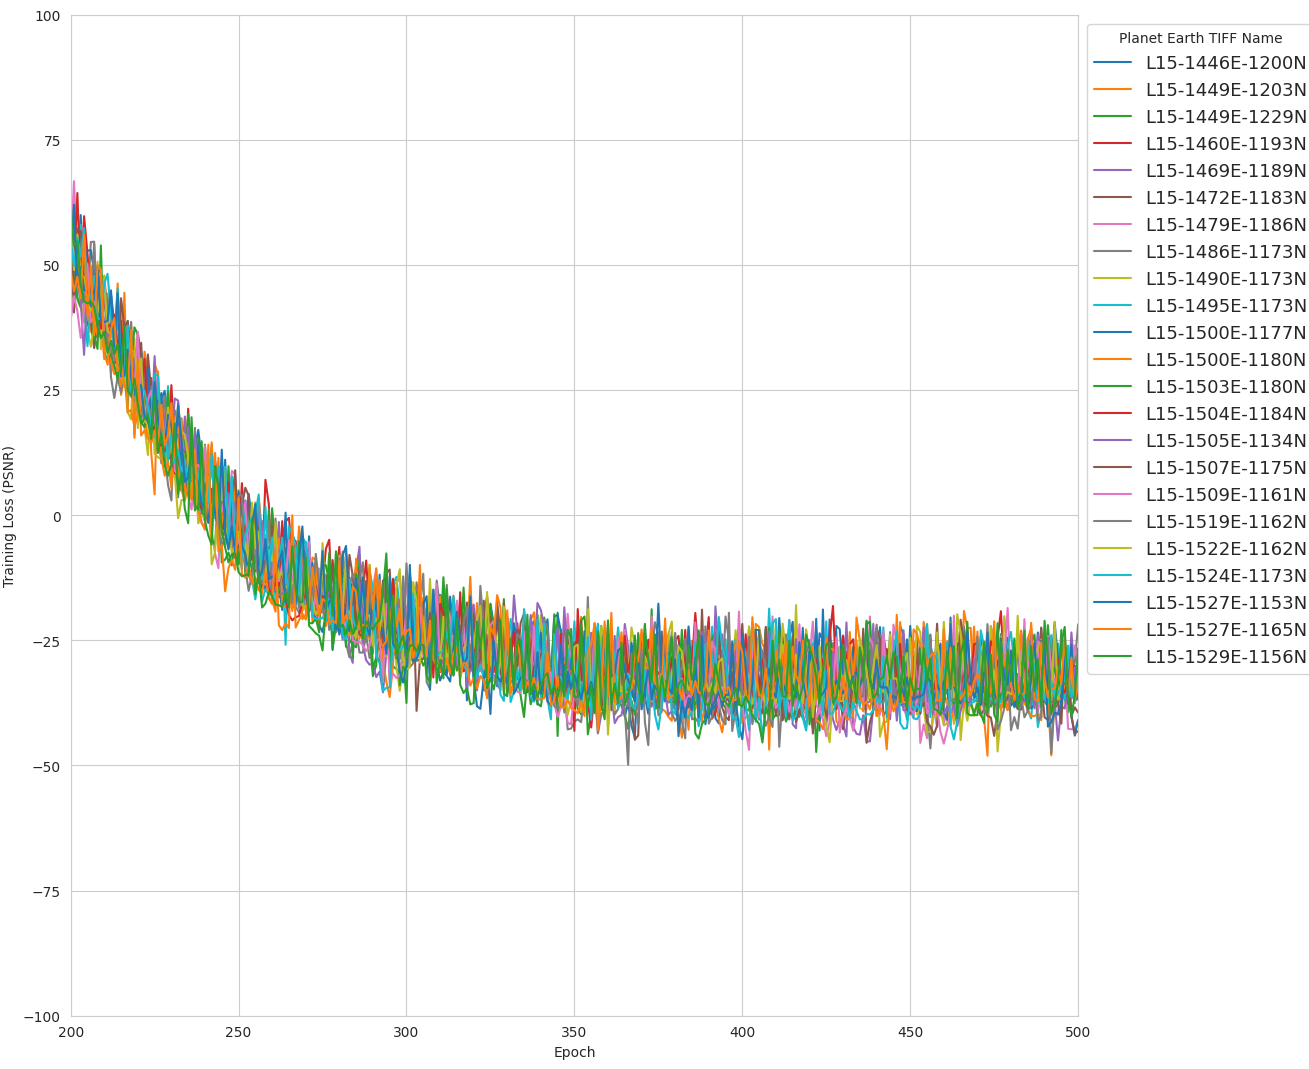

In [17]:
sns.set_style('whitegrid')
palette = sns.dark_palette("red", 23, reverse=True)
rcParams['figure.figsize'] = 13,13
palette = sns.dark_palette("red", 23, reverse=True)
for idx, history in enumerate(histories):
  plt.plot(list(range(1,501)), history['loss'], label=all_india_2020[idx][:-4:].split('//')[2])

plt.legend(title='Planet Earth TIFF Name', bbox_to_anchor=(1, 1), prop={'size': 13})
plt.xlabel('Epoch')
plt.xlim(200,500)
plt.ylim(-100, 100)
plt.ylabel('Training Loss (PSNR)')
plt.savefig('visualisations/training_loss_excluding_different_TIFFs.pdf')
sns.reset_defaults()

In [ ]:
file_name = all_india_2020[13]
tiff = load_tiff(file_name)
masked, _, _ = create_kiln_mask(file_name, area_of_interest)
labels = get_mask_kilns(area_of_interest, mask=masked)

threshold_values = np.linspace(0, 1, 10, endpoint=False)

for epoch in range(28000, 42000, 2000):
    roc = {str(threshold):[0,0,0] for threshold in threshold_values}
    model.load_weights(f'networks/unet_large/{model_name}/{model_name}_epoch_{epoch}.h5')
    for threshold in threshold_values:
        p, ttp, ffp = get_accuracy(file_name, model, labels=labels, threshold=threshold)
        roc[str(threshold)][0] += p
        roc[str(threshold)][1] += ttp
        roc[str(threshold)][2] += ffp 

    print(epoch, roc)

In [ ]:
counter = 0
for idx, file_name in enumerate(all_india_2020):
    # file_name = all_india_2020[13]
    masked, _, _ = create_kiln_mask(file_name, area_of_interest)
    labels = get_mask_kilns(area_of_interest, mask=masked)
    if idx != 13:
        print(file_name, get_accuracy(file_name, model, labels=labels, threshold=0.5), weights[counter])
        counter += 1

In [ ]:
model_threshold_data = pd.DataFrame({})
threshold_values = np.linspace(0, 0.9, 7, endpoint=True)

for epoch in range(40000, 53000, 1000):
  model.load_weights(f'networks/unet_large/{model_name}/{model_name}_epoch_{epoch}.h5')
  roc = {str(threshold):[0,0,0] for threshold in threshold_values}
  for threshold in threshold_values:
    if epoch in [26000] and threshold in [0]:
      continue
    p, ttp, ffp = get_accuracy(file_name, area_of_interest, model, labels=labels, threshold=threshold)
    roc[str(threshold)][0] += p
    roc[str(threshold)][1] += ttp
    roc[str(threshold)][2] += ffp 
  
  roc_precison = [ 1 if (item[1]==0 and item[2]==0) else item[1]/(item[1]+item[2]) for item in roc.values()]
  roc_recall = [ 1 if item[0]==0 else item[1]/(item[0]) for item in roc.values()]
  a = pd.DataFrame({'Precision':roc_precison, 'Recall':roc_recall, 'Threshold': threshold_values, 'Epoch': epoch})

  model_threshold_data = pd.concat([model_threshold_data, a])
  
model_threshold_data.head(10)

In [ ]:
model_threshold_data[np.logical_and(model_threshold_data.Precision > 0.5, model_threshold_data.Recall > 0.5)]

In [ ]:
selected = model_threshold_data
interval = 5000
start = 5000
selected_epochs = range(start, 40000+interval, interval)
selected = model_threshold_data[np.logical_and(model_threshold_data['Epoch'] % interval == 0, model_threshold_data['Epoch'] >= start)]
selected = selected[selected.Threshold != 0 ]
selected = selected[selected.Epoch != 0 ]
palette = sns.dark_palette("red", len(selected.Epoch.unique()), reverse=True)
sns.palplot(palette)

In [ ]:
sns.set_style('whitegrid')
rcParams['figure.figsize'] = 13, 13
for idx, epoch in enumerate(selected.Epoch.unique()):
  plt.scatter(selected[selected.Epoch == epoch].Precision, selected[selected.Epoch == epoch].Recall, s=400*selected[selected.Epoch == epoch].Threshold +50, label=str(epoch), c=palette[idx])
  plt.plot(selected[selected.Epoch == epoch].Precision, selected[selected.Epoch == epoch].Recall, ls="--")

plt.legend(title='Epoch', bbox_to_anchor=(1, 1), prop={'size': 13})
plt.xlim(0,1.02)
plt.ylim(0,1)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.savefig('visualisations/ROC_thresholds_across_epochs.pdf')
sns.reset_defaults()

In [ ]:
model_name

In [ ]:
with open('visualisations/training_progress/constant_image/constant_input.pkl', 'rb') as f:
    inputs = pickle.load(f)
with open('visualisations/training_progress/constant_image/constant_target.pkl', 'rb') as f:
    outputs = pickle.load(f)

num_predictions = range(0,7500, 1500)
f, axs = plt.subplots(2, len(num_predictions)+2, figsize=(20, 12))
axs[0,0].imshow(inputs[0])
axs[0,0].set_title('Input')
axs[0,1].imshow(outputs[0])
axs[0,1].set_title('Mask')
for idx, epoch in enumerate(list(num_predictions), 2):
    model.load_weights(f'networks/unet_large/{model_name}/{model_name}_epoch_{epoch}.h5')
    prediction = model.predict(np.expand_dims(inputs[0], axis=0), verbose=0)
    axs[0, idx].imshow(np.squeeze(prediction))
    axs[0, idx].set_title(f'Epoch {epoch}')

model_name = 'unet_large_all_india_2020_l1_elu_ssim_0.0001_bilinear'

axs[1,0].imshow(inputs[0])
axs[1,0].set_title('Input')
axs[1,1].imshow(outputs[0])
axs[1,1].set_title('Mask')
for idx, epoch in enumerate(list(num_predictions), 2):
    model.load_weights(f'networks/unet_large/{model_name}/{model_name}_epoch_{epoch}.h5')
    prediction = model.predict(np.expand_dims(inputs[0], axis=0), verbose=0)
    axs[1, idx].imshow(np.squeeze(prediction))
    axs[1, idx].set_title(f'Epoch {epoch}')


for ax in axs.flatten():
    ax.axis('off')

plt.subplots_adjust( wspace=0.01, hspace=-0.5)
f.tight_layout()
plt.savefig(f'visualisations/progess_psnr_ssim.pdf')

In [ ]:
axs[0,0].imshow(inputs[0])
axs[0,0].set_title('Input')
axs[0,1].imshow(outputs[0])
axs[0,1].set_title('Mask')
for idx, epoch in enumerate(list(num_predictions), 2):
    model.load_weights(f'networks/unet_large/{model_name}/{model_name}_epoch_{epoch}.h5')
    prediction = model.predict(np.expand_dims(inputs[0], axis=0), verbose=0)
    axs[0, idx].imshow(np.squeeze(prediction))
    axs[0, idx].set_title(f'Epoch {epoch}')

plt.show()

In [ ]:
file_name = all_india_2020[0]
tiff = load_tiff(file_name)
masked, _, _ = create_kiln_mask(file_name, area_of_interest)
labels = get_mask_kilns(area_of_interest, mask=masked)

threshold_values = np.linspace(0.15, 0.9, 6, endpoint=True)

roc = {str(threshold):[0,0,0] for threshold in threshold_values}
model.load_weights(f'networks/unet_large/{model_name}/{model_name}_epoch_35000.h5')
for threshold in threshold_values:
    p, ttp, ffp = get_accuracy(file_name, area_of_interest, model, labels=labels, threshold=threshold)
    roc[str(threshold)][0] += p
    roc[str(threshold)][1] += ttp
    roc[str(threshold)][2] += ffp 

roc

In [ ]:
file_name = all_india_2020[0]
tiff = load_tiff(file_name)
masked, _, _ = create_kiln_mask(file_name, area_of_interest)
labels = get_mask_kilns(area_of_interest, mask=masked)

threshold_values = np.linspace(0.15, 0.9, 6, endpoint=True)

roc = {str(threshold):[0,0,0] for threshold in threshold_values}
model.load_weights(f'networks/unet_large/{model_name}/{model_name}_epoch_35000.h5')
for threshold in threshold_values:
    p, ttp, ffp = get_accuracy(file_name, area_of_interest, model, labels=labels, threshold=threshold)
    roc[str(threshold)][0] += p
    roc[str(threshold)][1] += ttp
    roc[str(threshold)][2] += ffp 

roc

In [ ]:
roc_precison = [item[1]/(item[1]+item[2]) for item in roc.values()]
roc_recall = [item[1]/(item[0]) for item in roc.values()]
roc_precison, roc_recall

In [ ]:
roc_precison = [item[1]/(item[1]+item[2]) for item in roc.values()]
roc_recall = [item[1]/(item[0]) for item in roc.values()]
data = pd.DataFrame({'Precision':roc_precison, 'Recall':roc_recall, 'Threshold': threshold_values})
# sns.set_style('whitegrid')
rcParams['figure.figsize'] = 8, 8
sns.scatterplot(data=data, x="Precision", y="Recall", hue='Threshold', palette='Reds')#.set(title='ROC for different thresholds on Validation TIFF')
plt.legend(labels=data['Threshold'].round(1))
plt.savefig('visualisations/ROC_thresholds.pdf')
sns.reset_defaults()

In [ ]:
longtitude_size = []
latitude_size = []
for tiff in all_india_2020:
    _, locations, _ = create_kiln_mask(tiff, area_of_interest)
    longtitude_size.extend([ l[1]-l[0] for l in locations ])
    latitude_size.extend([ l[3]-l[2] for l in locations ])

In [ ]:
data = {'Longtitude (pixels)': longtitude_size, 'Latitude (pixels)': latitude_size}
data = pd.DataFrame(data=data)
sns.set_style('whitegrid')
g = sns.pairplot(data, height=4, kind='hist')
g.map_lower(sns.kdeplot, levels=3, color=".2")
g.map_upper(sns.kdeplot, levels=3, color=".2")
g.savefig('visualisations/distribution_kiln_sizes.pdf')
sns.reset_defaults()

In [ ]:
file_name = all_india_2020[1]
tiff = load_tiff(file_name)
mask, locations, types = create_kiln_mask(file_name, area_of_interest)
model.load_weights(f'networks/unet_large/{model_name}/{model_name}_epoch_28700.h5')
print(model.name)
left, right, top, bottom = locations[4]
fill_width = 300-(right-left)
fill_height = 300-(bottom-top)
lb = random.randint(0, fill_width)
rb = fill_width - lb
tb = random.randint(0, fill_height)
bb = fill_height - tb
test_img = np.expand_dims(tiff[top-tb:bottom+bb,left-lb:right+rb], axis=0)
prediction = np.squeeze(model.predict(test_img))

f, axs = plt.subplots(1, 5, figsize=(45,45))
axs[0].imshow(tiff[top-tb:bottom+bb,left-lb:right+rb])
axs[1].imshow(mask[top-tb:bottom+bb,left-lb:right+rb])
a = np.where(mask[top-tb:bottom+bb,left-lb:right+rb] > 0, 1, 0)
axs[2].imshow(a)
axs[3].imshow(prediction)
p = np.where(prediction > 0.1, 1, 0)
axs[4].imshow(p)

titles = ['image', 'mask', 'rounded mask', 'prediction', 'rounded prediction']
for idx, ax in enumerate(axs):
    ax.set_title(titles[idx])
    ax.axis('off')